In [1]:
import sys
import os
import math
import numpy as np
import galsim
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline
#timekeeping
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

//anaconda/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


Installed autotime.py. To use it, type:
  %load_ext autotime


In [2]:
#constants
#didn't use psf sigma constants
gal1_flux_thru_r = 1.e5 #the flux through r of gal1 we want. (not passed when gal1 is created)
gal1_sigma = 5.
psf1_sigma = 1.

gal2_flux_thru_r = 5.e4 
gal2_sigma = 4.
psf2_sigma = 0.5

pixel_scale = 1.

time: 9.65 ms


In [3]:
#where to find and output data
path, filename = os.path.split("__file__")
datapath = os.path.abspath(os.path.join(path, "data/"))
outpath = os.path.abspath(os.path.join(path, "output/"))

time: 51.5 ms


In [76]:
#read in the LSST filters
filter_names = 'ugrizy'
filters = {}
filter_filenames = {}
for filter_name in filter_names:
    filter_filename = os.path.join(datapath, 'LSST_{0}.dat'.format(filter_name))
    filters[filter_name] = galsim.Bandpass(filter_filename)
    filters[filter_name] = filters[filter_name].withZeropoint(0.,effective_diameter=1.,exptime=1.)

time: 197 ms


In [4]:
#define the components of galaxies

sed1 = galsim.SED(spec="wave",wave_type='nm',flux_type='fphotons')
sed1 = sed1.withFlux(gal1_flux_thru_r,filters['r'])

sed2 = galsim.SED(spec="300-wave",wave_type = 'nm',flux_type = 'fphotons')
sed2 = sed1.withFlux(gal2_flux_thru_r,filters['r'])

gal1 = galsim.Gaussian(flux=1.,sigma=gal1_sigma)
psf1 = galsim.Moffat(beta=2.5,fwhm=0.5)
ra = galsim.HMS_Angle("14:03:13")
dec = galsim.DMS_Angle("54:20:57")
m101 = galsim.CelestialCoord(ra,dec)
latitude = 19.8207*galsim.degrees
HA=-1.0*galsim.hours
za,pa = galsim.dcr.zenith_parallactic_angles(m101,HA=HA,latitude=latitude)
chrom_psf1 = galsim.ChromaticAtmosphere(psf1,500.,obj_coord=m101,latitude=latitude,HA=HA)


gal2 = galsim.Gaussian(flux=1.,sigma=gal2_sigma)
psf2 = galsim.Gaussian(flux=1.,sigma = psf2_sigma)
ra = galsim.HMS_Angle("14:13:13")
dec = galsim.DMS_Angle("54:50:57")
rand_thing_next_to_m101 = galsim.CelestialCoord(ra,dec)
latitude_seoul = 37.5665*galsim.degrees #seoul
za,pa = galsim.dcr.zenith_parallactic_angles(rand_thing_next_to_m101,HA=HA,latitude=latitude)
chrom_psf2 = galsim.ChromaticAtmosphere(psf2,500.,obj_coord=rand_thing_next_to_m101,latitude=latitude_seoul,HA=HA)

chrom_gal1 = gal1*sed1
chrom_gal2 = gal2*sed2

chrom_total1 = galsim.Convolve([chrom_gal1,chrom_psf1])
chrom_total2 = galsim.Convolve([chrom_gal2,chrom_psf2])

time: 52.8 ms


In [5]:
#note: sed must have been normalized from specified flux@filter in advance.
def photshoot(x_pixel=128, y_pixel=128, gal_array = [], sed_array=[], psf_array =[], bounds_array = [], filter_dic=filters):
    
    #check that input arrays are same length
    check_list = [gal_array, sed_array, psf_array, bounds_array]
    one_length = len(check_list[0])
    if all(len(x) == one_length for x in check_list):
        pass
    else:
        raise TypeError("input arrays must be same length")
    
    #check that bounds have length 4
    for bounds in bounds_array:
        if len(bounds) != 4:
            raise TypeError("bounds must have length 4")
    
    waverange = np.arange(300.,1100.)
    
    #normalizes given list to unity to make PDF
    def normalize(list):
        return [float(i)/(sum(list)) for i in list]

    #randomly generate lams according to PDF formed from given sed and filter
    def generate_lams(sedf,num,filterf=None):
        #num: number of photons through filterf
        if filterf==None:
            raw = sedf
        else:
            raw = sedf*filterf
        rawlist=[]
        for lam in waverange: 
            rawlist.append(raw.__call__(lam))
        norm = normalize(rawlist)  
        return np.random.choice(waverange,num,True,norm)
    
    #generate wavelengths, picked from PDF
    #lams[filter_name] = [list of lams for galaxy 1, list of lams for gal2, ...]
    lams={}
    for filter_name,filter_ in filter_dic.iteritems():
        lams[filter_name] = []
        for sed_item in sed_array:
            lams[filter_name].append(generate_lams(sed_item,sed_item.calculateFlux(filter_),filter_))
    
    #total combined SED
    combined_sed = np.sum(sed_array)
    
    #total number of galaxies
    n = len(sed_array)
    
    #declare dic of output images
    photinline = {}
    
    for filter_name, filter_ in filters.iteritems():
        #larger image to draw all our galaxies into
        photimg = galsim.ImageF(x_pixel, y_pixel, scale=1.)
        #make subimages (bounds) for each galaxy
        gal_images = []
        for bounds in bounds_array:
            gal_images.append(photimg[galsim.BoundsI(bounds[0],bounds[1],bounds[2],bounds[3])])
        
        #choose_gal looks like [0,0,1,2,2,2,3,...] i.e. weights occurrence of num_label with gal_flux
        #i.e. galaxies with more flux will be chosen more often
        choose_gal = []
        for num_label in np.arange(n):
            choose_gal += [num_label]*(sed_array[num_label].calculateFlux(filter_))
        
        #choose_gal_rand uniform-randomly chooses from choose_gal, the total-flux # of times
        choose_gal_rand = np.random.choice(choose_gal, size=combined_sed.calculateFlux(filter_))
        
        #note random variable RV equals num_label of galaxy
        for RV in choose_gal_rand:
            lam = np.random.choice(lams[filter_name][RV])
            chrompart = sed_array[RV]*filter_
            inter_chromgal = gal_array[RV]*chrompart.withFluxDensity(1.,lam)
            inter_chromtotal = galsim.Convolve([inter_chromgal,psf_array[RV]]) #chromtot = chromgal + psf
            mono = inter_chromtotal.evaluateAtWavelength(lam)
            mono.drawImage(image=gal_images[RV], method='phot',scale=1.,n_photons=1,add_to_image=True)
        photinline[filter_name] = photimg
        
    return photinline


time: 115 ms


In [62]:
#call my photon shooting method on one galaxy
photinline = photshoot(gal_array=[gal1], sed_array=[sed1],psf_array=[chrom_psf1],bounds_array=[[20,115,1,96])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:67: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


time: 17min 21s


In [63]:
#flux per filter of my photon shooting images
for filter_name, filter_ in filters.iteritems():
    print filter_name," : ",np.sum(photinline[filter_name].array)

g  :  262990.0
i  :  384281.0
r  :  349999.0
u  :  51224.0
y  :  229621.0
z  :  353720.0
time: 37.9 ms


In [64]:
#expected flux per filter
for filter_name, filter_ in filters.iteritems():
    print filter_name, sed1.calculateFlux(filter_)

g 262990.417459
i 384281.390781
r 350000.0
u 51224.5292096
y 229621.018812
z 353720.539948
time: 8.83 ms


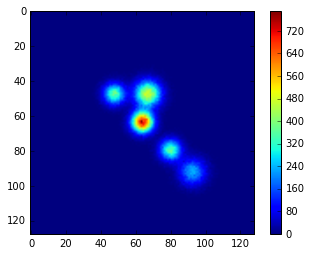

time: 597 ms


In [65]:
#view the photon shooting image
plt.imshow(photinline['g'].array)
plt.colorbar()

# Generate FFT Images

In [72]:
#here is code for making FFT images of the same galaxy
fftinline = {}
chromgal1 = gal1*sed1
chrom_final = galsim.Convolve([chromgal1,chrom_psf1])

for filter_name, filter_ in filters.iteritems():
    fftimg = galsim.ImageF(128, 128, scale = 1.)
    bounded = fftimg[galsim.BoundsI(20,115,1,96)]
    chrom_final.drawImage(filter_, image = bounded, scale = 1., method='fft', add_to_image=True)
    fftinline[filter_name] = fftimg

time: 2.45 s


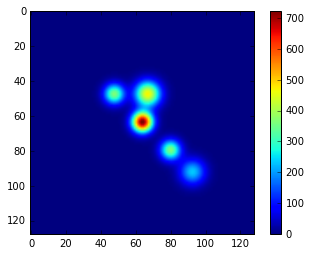

time: 438 ms


In [73]:
#view the FFT image
plt.imshow(fftinline['g'].array)
plt.colorbar()

# Chi-sq Comparison with FFT

In [74]:
#just take pixels with value > 0.5, to reduce computation time

leftphotz = {}
leftfftz = {}
ilist = {}
for filter_name,filter_ in filters.iteritems():
    leftphotz[filter_name] = []
    leftfftz[filter_name] = []
    ilist[filter_name] = []
    for i in np.arange(128*128):
        if photinline[filter_name].array.flatten()[i]>0.5:
            ilist[filter_name].append(i)
            leftphotz[filter_name].append(photinline[filter_name].array.flatten()[i])
            leftfftz[filter_name].append(fftinline[filter_name].array.flatten()[i])
    print len(ilist[filter_name]), len(leftphotz[filter_name])

3112 3112
3209 3209
3224 3224
2529 2529
3073 3073
3196 3196
time: 1.46 s


In [75]:
from scipy.stats import chisquare
chis = {}
pvals = {}
chis_2d = {}
pvals_2d = {}
for filter_name,filter_ in filters.iteritems():
    chis[filter_name],pvals[filter_name] = chisquare(leftfftz[filter_name],f_exp=leftphotz[filter_name],ddof = len(ilist[filter_name]))
    #chis_2d[filter_name], pvals_2d[filter_name] = chisquare(phots[filter_name],f_exp=ffts[filter_name],axis=None)
    print filter_name, chis[filter_name]/len(ilist[filter_name])

g 1.02389345929
i 0.990176249903
r 0.961042304784
u 1.04713883406
y 1.03053831379
z 0.966441358583
time: 11.4 ms


In [57]:
def my_chisq(obslist, explist):
    errorlist = []
    chisum = 0
    for i in np.arange(len(obslist)):
        errorlist.append(float((obslist[i]-explist[i])**2)/obslist[i])
    chisum = sum(errorlist)
    return chisum, errorlist

time: 5.83 ms


In [58]:
chisums = {}
errorlists = {}
for filter_name,filter_ in filters.iteritems():
    chisums[filter_name], errorlists[filter_name] = my_chisq(leftphotz[filter_name],leftfftz[filter_name])

time: 53.6 ms
